# Demo 2: Scaling relations and volcano plots for metal oxides
In this demonstration you will learn how to plot scaling relations and volcano plots in python. We will use the O and OH adsorption energies from our 2022 transition metal oxides dataset https://www.catalysis-hub.org/publications/ComerUnraveling2022 (publication link: https://pubs.acs.org/doi/10.1021/acs.jpcc.2c02381)

Start by connecting to the remote server and fetching the pandas dataframe (as covered in previous first demonstration):


In [4]:
from cathub.cathubsql import CathubSQL
db = CathubSQL()

In [5]:
dataframe = db.get_dataframe(pub_id='ComerUnraveling2022')
dataframe.to_pickle('ComerUnraveling2022.pickle')
print('Data downloaded!')

Querying database

Data downloaded!


Now you can read the data from a local pickle file:

In [6]:
import pandas
dataframe = pandas.read_pickle('ComerUnraveling2022.pickle')

Start by examining the unique chemical reactions and facets for the dataset, for example:

In [7]:
print(dataframe[['reaction_id', 'surface_composition', 'facet', 'equation', 'reaction_energy']].to_markdown())

|     |   reaction_id | surface_composition   |   facet | equation                     |   reaction_energy |
|----:|--------------:|:----------------------|--------:|:-----------------------------|------------------:|
|   0 |        436020 | FeO2-rutile           |     110 | H2O(g) - H2(g) + * -> O*     |         4.7116    |
|   1 |        436021 | FeO2-rutile           |     110 | H2O(g) - 0.5H2(g) + * -> HO* |         1.88222   |
|   2 |        436022 | FeO2-rutile           |     100 | H2O(g) - H2(g) + * -> O*     |         4.526     |
|   3 |        436023 | FeO2-rutile           |     100 | H2O(g) - 0.5H2(g) + * -> HO* |         1.83325   |
|   4 |        436024 | MnO2-rutile           |     110 | H2O(g) - H2(g) + * -> O*     |         4.09478   |
|   5 |        436025 | MnO2-rutile           |     110 | H2O(g) - 0.5H2(g) + * -> HO* |         1.5347    |
|   6 |        436026 | MnO2-rutile           |     100 | H2O(g) - H2(g) + * -> O*     |         4.01555   |
|   7 |        4360

## Atomic structures

Visualize the structures for the 110 and 100 facets using the ``get_atoms_for_reaction()`` function:

In [8]:
from ase.visualize import view
print('Structure names 110 Fe:', dataframe['atoms_name'][0])
print('Structure names 100 Fe:', dataframe['atoms_name'][2])
atoms_110_Fe = db.get_atoms_for_reaction(436020)
atoms_100_Fe = db.get_atoms_for_reaction(436022)
view(atoms_110_Fe[0], viewer='ngl')

Structure names 110 Fe: ['Ostar', 'H2Ogas', 'star', 'H2gas', 'bulkrutile']
Structure names 100 Fe: ['H2Ogas', 'Ostar', 'H2gas', 'star', 'bulkrutile']
Querying database
Querying database


In [9]:
view(atoms_100_Fe[1], viewer='ngl')

## Scaling relations
Use your favorite python plotting module to plot the OH vs. O scaling (i.e. plotting OH vs O adsorption energies).

Example: using matplotlib/pylab you can plot the scaling relation like this:

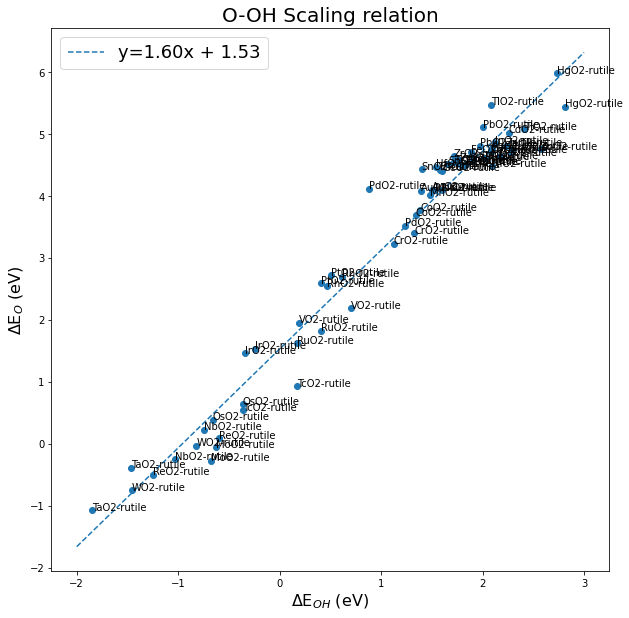

In [10]:
import numpy as np
import pylab as p

loc_O = (dataframe["equation"] =='H2O(g) - H2(g) + * -> O*') 
loc_OH = (dataframe["equation"] =='H2O(g) - 0.5H2(g) + * -> HO*') 

ads_O = dataframe[loc_O]
ads_OH = dataframe[loc_OH]

# Combine O and OH in one dataframe, matching on surface compositions
dataframe_together = ads_O.merge(ads_OH, 
                                 on=['surface_composition', 'facet'],
                                 suffixes=('_O', '_OH'))

x_data = dataframe_together['reaction_energy_OH']
y_data = dataframe_together['reaction_energy_O']
p.figure(figsize=(10,10))
p.scatter(x_data, y_data)
for i, txt in enumerate(dataframe_together['surface_composition']):
    p.gca().annotate(txt,
        (x_data[i],
         y_data[i]))
p.title('O-OH Scaling relation', fontsize=20)
p.xlabel('$\Delta$E$_{OH}$ (eV)', fontsize=16)
p.ylabel('$\Delta$E$_{O}$ (eV)', fontsize=16)


fit = np.polyfit(x_data,
                 y_data,
                 1)

a = fit[0]
b = fit[1]
xfit = np.array([-2, 3])
yfit = a * xfit + b
             
p.plot(xfit, yfit, '--', label='y={:.2f}x + {:.2f}'.format(a,b))
p.legend(prop={'size':18})

p.show()

## Volcano plots

The Oxygen evolution reaction (OER) overpotential tends to form a volcano relationship with the O-OH adsorption energy difference. 

First we will use scaling relations between OH and OOH to estimate the OOH adsorption energy.


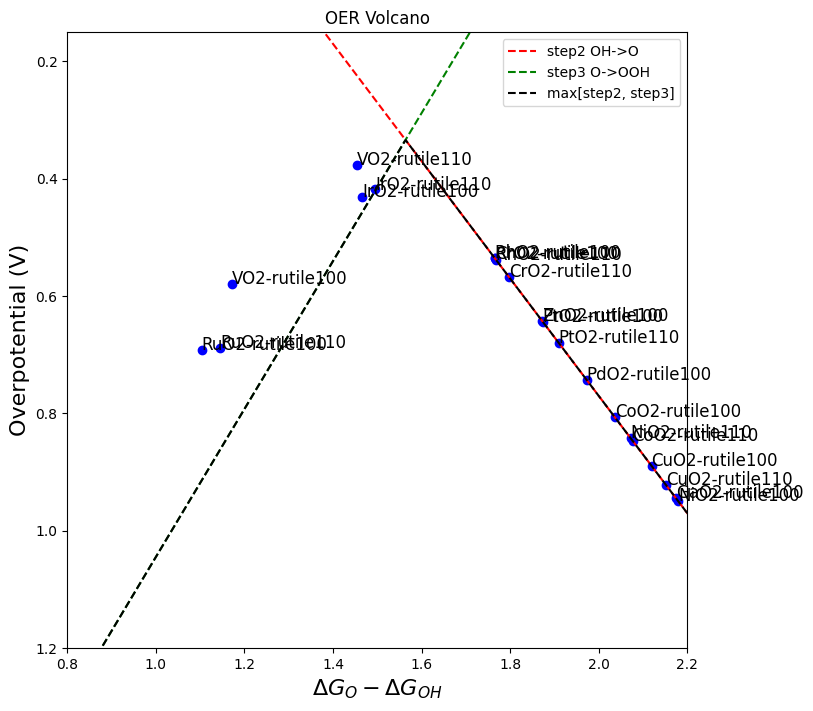

In [16]:
import pylab as plt
import numpy as np

x_data = dataframe_together['reaction_energy_OH']
y_data = dataframe_together['reaction_energy_O']

def get_overpotential(dGOH, dGO, dGOOH):
    """
    ideal step = 1.23 eV
    
                         _O2_
                   _OOH_|  ->  step4
               _O_|    ->  step3
          _OH_|   ->  step2  
    _H2O_|  ->  step1
    """
    step1 = dGOH
    step2 = dGO - dGOH
    step3 = dGOOH - dGO
    step4 = 4 * 1.23 - dGOOH
    #step_energies = [step1, step2, step3, step4]
    step_energies = [step2, step3]  # Only consider step2 and step 3 for simplicity
    overpotential = np.max(step_energies) - 1.23
    return overpotential

def ooh_oh_scaling(doh):
    """Oxide scaling for *OH vs *OOH (from previous studies)"""
    dooh = 0.8443 * doh + 3.136
    return dooh

i = 0
materials = dataframe_together['surface_composition'].values
facets = dataframe_together['facet'].values

p.figure(figsize=(8,8))
for dEOH, dEO in zip (x_data, y_data):
    dGO = dEO - 0.014 # Free energy correction O (from previous studies)
    dGOH = dEOH + 0.2975  # Free energy correction OH (from previous studies)
    X = dGO - dGOH
    dGOOH = ooh_oh_scaling(dGOH)
    
    overpotential = get_overpotential(dGOH, dGO, dGOOH)
    
    plt.plot(X, overpotential, 'bo')
    plt.annotate(materials[i] + str(facets[i]), (X, overpotential), fontsize=12)
    i += 1
    

c = 0.8443 
d = 3.136

x = np.linspace(0, 2.5, 1000)  # O - OH

# Step 2 and 3 as a function of O-OH energy
# using OOH vs OH and O vs OH scaling relations

step_2 = x - 1.23  # OH -> O step
step_3 = (c-a) * (x-b) / (a-1)  + d - b -  1.23  # O -> OOH step


volcano_line = []
for i in range(len(x)):
    volcano_line += [np.max([step_2[i], step_3[i]])]

plt.plot(x, step_2, '--',  color='r', label='step2 OH->O')
plt.plot(x, step_3, '--',  color='g', label='step3 O->OOH')

plt.plot(x, volcano_line, '--',  color='k', label='max[step2, step3]')

plt.ylim(1.2, 0.15)
plt.xlim(0.8, 2.2)
plt.legend()
plt.title('OER Volcano')
plt.xlabel('$\Delta G_{O} - \Delta G_{OH}$', fontsize=16)
plt.ylabel('Overpotential (V)', fontsize=16)
plt.show()

## Visualizing COHP and ICOHP curves

In the example below we will use the `aloha` Python code, developed by SUNCAT postdoc Ara Cho, to plot the COHP + ICOHP curves for bulk RuO2

To install the code do:
```
    git clone https://github.com/aracho12/aloha.git
```
and add the directory to $PYTHONPATH. Also install dependencies: 
```
    pip install monty
    pip install mendeleev
 ```   
The code takes the Lobster output file `COHPCAR.lobster` and the VASP `POSCAR` files as input (example files are in tutorial folder)


In [11]:
from ase.io import read
atoms = read('POSCAR')

view(atoms, viewer='ngl')

FileNotFoundError: [Errno 2] No such file or directory: 'POSCAR'

label ele1  idx1 ele2  idx2         pair  -ICOHP  distance
    1    O     2   Ru     0 O2(p)-Ru0(d) 2.01519  1.955089
    2    O     3   Ru     0 O3(p)-Ru0(d) 2.01522  1.955089
    3    O     4   Ru     0 O4(p)-Ru0(d) 1.73585  1.994772
    4    O     4   Ru     0 O4(p)-Ru0(d) 1.73586  1.994771
    5    O     5   Ru     0 O5(p)-Ru0(d) 1.73594  1.994763
    6    O     5   Ru     0 O5(p)-Ru0(d) 1.73594  1.994762
    7    O     2   Ru     1 O2(p)-Ru1(d) 1.73571  1.994765
    8    O     2   Ru     1 O2(p)-Ru1(d) 1.73573  1.994766
    9    O     3   Ru     1 O3(p)-Ru1(d) 1.73573  1.994765
   10    O     3   Ru     1 O3(p)-Ru1(d) 1.73573  1.994766
   11    O     4   Ru     1 O4(p)-Ru1(d) 2.01555  1.955082
   12    O     5   Ru     1 O5(p)-Ru1(d) 2.01555  1.955090
				-ICOHP sum:21.94800


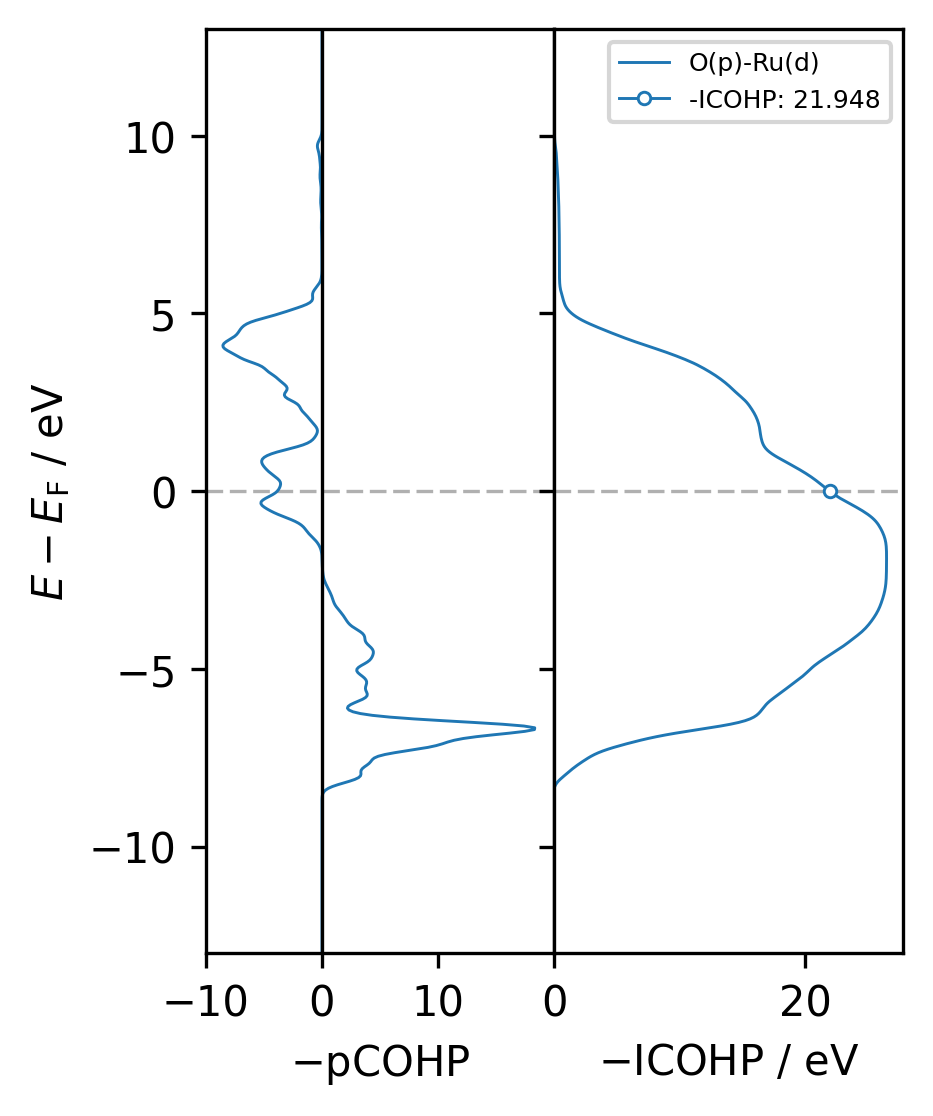

Figure saved as cohp.png
Data saved as cohp.tsv


In [18]:
from aloha.cohpplot import * 
Cohpplot(sum_labels=True)

## Challenge: Inspect the correlation between ICOHP and O and OH adsorption energies

As discussed in the paper highlighted above, the intrgrated Crystal orbital Hamiltonian population (ICOHP) for the Metal-Oxygen bonds in the bulk oxide is an important descriptor for O and OH adsorption energetics. Test the correlation yourself by downloading COHP data from here: https://github.com/SUNCAT-Center/CatHub/tutorials/SUNCAT_summer_institute_2023/


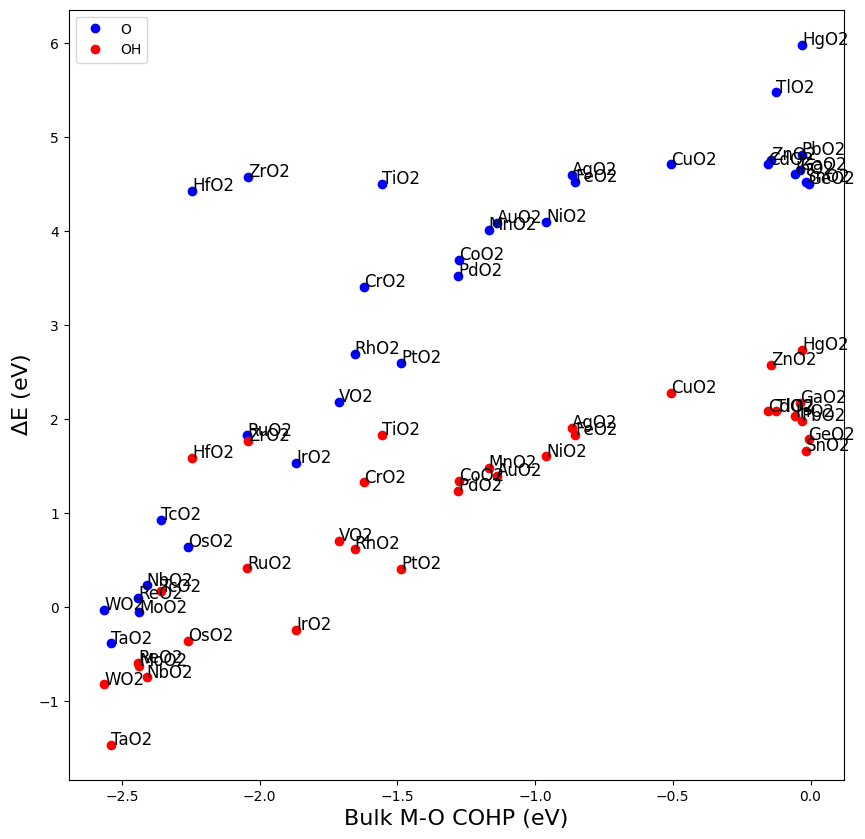

In [19]:
import pylab as p
import json

p.rcdefaults()
bulk_icohp_data = json.load(open('bulk_COHP_data.json', 'r'))
dataframe_filter= dataframe[(dataframe['facet']=='100')]
p.figure(figsize=(10,10))
i = 0
for structure, data in bulk_icohp_data.items():
    comp = structure.split('_')[1]
    df = dataframe_filter[(dataframe_filter['surface_composition']== comp + '-rutile')]
    if len(df) == 0:
        continue
    E_OH = df[df["equation"] =='H2O(g) - 0.5H2(g) + * -> HO*']['reaction_energy'].values
    E_O = df[df["equation"] =='H2O(g) - H2(g) + * -> O*']['reaction_energy'].values
    icohp = data['integral']
    if i == 0:
        p.plot(-icohp, E_O, 'bo', label='O')
        p.plot(-icohp, E_OH, 'ro', label='OH')
    else:
        p.plot(-icohp, E_O, 'bo')
        p.plot(-icohp, E_OH, 'ro')
    p.annotate(comp, (-icohp, E_O), fontsize=12)
    p.annotate(comp, (-icohp, E_OH), fontsize=12)
    i += 1
p.xlabel('Bulk M-O COHP (eV)', fontsize=16)
p.ylabel('$\Delta$E (eV)', fontsize=16)
p.legend()
p.show()